In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopy
from geopy import distance
from geopy.distance import vincenty
# from tqdm import tqdm
# tqdm.pandas()
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
import numpy as np

# import eli5
# from eli5.sklearn import PermutationImportance
# from skopt.space import Real
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Using TensorFlow backend.
C:\Users\lorie\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\lorie\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
train = pd.read_csv('listings.csv.gz', compression='gzip')
price_df = pd.read_csv('listings.csv')


In [3]:
train.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10291,https://www.airbnb.com/rooms/10291,20190306190816,2019-03-06,Spacious Cottage in Mid-City!,NaN,"Spacious house located in Mid-City, New Orlean...","Spacious house located in Mid-City, New Orlean...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/99566384/f...,NaN,31004,https://www.airbnb.com/users/show/31004,Jill,2009-08-11,"New Orleans, Louisiana, United States",I'm from New Orleans and work in the insurance...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/31004/profile...,https://a0.muscache.com/im/users/31004/profile...,Navarre,1,1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"New Orleans, LA, United States",Navarre,Navarre,NaN,New Orleans,LA,70124,New Orleans,"New Orleans, LA",US,United States,29.98666,-90.10928,t,Cottage,Entire home/apt,4,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$300.00,NaN,NaN,$0.00,$100.00,4,$0.00,2,365,2,2,365,365,2.0,365.0,4 weeks ago,t,13,32,60,331,2019-03-06,96,14,2011-03-07,2019-02-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,17STR-04686,"{""Louisiana State"","" New Orleans"","" LA""}",f,f,moderate,t,f,1,1,0,0,0.99
1,19091,https://www.airbnb.com/rooms/19091,20190306190816,2019-03-06,Fully Furnished Cozy Apartment,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,SEE SPECIAL REDUCED SUMMER PRICING! This apa...,CITY OF NEW ORLEANS STR LICENSE PERMIT NUMBER:...,none,"NorthWest Carrollton, where this apartment is ...",NaN,If you are going to use the trolley or bus sys...,Guests who stay for a week or longer will have...,The host is available for help with the apartm...,No smoking! No drugs. No pets. On street par...,NaN,NaN,https://a0.muscache.com/im/pictures/957168/75e...,NaN,72880,https://www.airbnb.com/users/show/72880,John,2010-01-23,"New Orleans, Louisiana, United States",I recently (2018) retired as the Director of B...,within an hour,100%,NaN,t,https://a0.muscache.com/im/users/72880/profile...,https://a0.muscache.com/im/users/72880/profile...,Riverbend,1,1,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"New Orleans, LA, United States",Uptown/Carrollton District,Leonidas,NaN,New Orleans,LA,70118,New Orleans,"New Orleans, LA",US,United States,29.96257,-90.11877,t,Apartment,Entire home/apt,3,1.0,

In [4]:

lon = -90.0680352
lat = 29.9585246
train['distance_center'] = train.apply(lambda x: vincenty((x['latitude'], x['longitude']), (lat, lon)).miles, axis = 1)




In [5]:
train['distance_center'].describe()

count    6632.000000
mean        1.946200
std         1.576078
min         0.029375
25%         0.913820
50%         1.662018
75%         2.597029
max        24.292619
Name: distance_center, dtype: float64

In [6]:
train['distance_center'].min()

0.029374828173485655

In [7]:
train = train.drop(columns=['listing_url','last_scraped','thumbnail_url', 'medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url','host_picture_url', 'neighbourhood','neighbourhood_group_cleansed','summary', 'neighborhood_overview','scrape_id','host_name','name', 'id', 'host_id', 'latitude', 'longitude', 'last_review', 'reviews_per_month'])


In [8]:
df = train.groupby(['neighbourhood_cleansed']).mean()
price_grouped = price_df.groupby(['neighbourhood']).mean()
price = price_grouped['price']

In [9]:
df['price']=price

In [10]:
df = df.replace([np.inf, -np.inf], np.nan)
df

,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,distance_center,price
neighbourhood_cleansed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Algiers Point,NaN,7.606557,7.606557,4.262295,1.426230,1.934426,2.573770,856.666667,2.540984,2.147541,612.426230,2.016393,2.409836,612.426230,612.426230,2.178689,612.426230,6.540984,17.836066,35.147541,173.114754,50.491803,23.426230,97.754386,9.877193,9.842105,9.982456,9.912281,9.824561,9.859649,2.491803,2.344262,0.147541,0.000000,1.148790,140.786885
Audubon,NaN,5.032787,5.032787,4.770492,1.602459,2.032787,2.704918,250.000000,2.786885,3.745902,610.745902,3.713115,4.040984,610.745902,610.745902,3.770492,610.745902,9.524590,22.803279,41.663934,155.598361,37.852459,17.918033,97.214286,9.883929,9.758929,9.982143,9.964286,9.919643,9.732143,2.254098,1.836066,0.418033,0.000000,3.612738,240.122951
Bayou St. John,NaN,5.128788,5.128788,4.280303,1.393939,1.787879,2.386364,1493.500000,2.151515,3.159091,666.537879,2.893939,3.681818,637.446970,655.022727,3.228030,637.772727,7.446970,18.204545,36.886364,139.772727,36.833333,14.628788,97.904000,9.928000,9.856000,9.976000,9.984000,9.736000,9.864000,2.621212,2.416667,0.204545,0.000000,1.529790,182.477273
Behrman,NaN,1.166667,1.166667,4.666667,1.375000,2.083333,2.583333,NaN,2.166667,1.916667,541.166667,1.916667,2.083333,541.166667,541.166667,1.975000,541.166667,9.916667,28.333333,52.583333,185.583333,15.166667,10.000000,94.888889,9.666667,9.555556,10.000000,10.000000,9.555556,9.777778,1.166667,1.083333,0.083333,0.000000,2.827476,122.750000
Black Pearl,NaN,14.137931,14.137931,3.655172,1.275862,1.724138,2.103448,NaN,2.206897,4.068966,571.413793,4.034483,4.275862,571.413793,571.413793,4.086207,571.413793,6.862069,17.344828,32.586207,145.551724,45.931034,18.413793,96.923077,9.923077,9.769231,10.000000,9.884615,9.846154,9.730769,3.206897,2.827586,0.379310,0.000000,4.092445,147.862069
Broadmoor,NaN,3.798387,3.798387,4.782258,1.403226,1.959677,2.685484,NaN,2.887097,2.032258,734.129032,1.975806,2.516129,734.129032,741.193548,2.095161,734.211290,8.185484,21.822581,41.016129,132.733871,45.645161,19.508065,96.905172,9.836207,9.655172,9.948276,9.965517,9.568966,9.732759,2.508065,1.911290,0.596774,0.000000,2.341418,159.427419
Bywater,NaN,37.238298,37.238298,4.097872,1.427660,1.787234,2.272340,765.000000,2.506383,2.744681,697.417021,2.625532,3.208511,671.553191,671.553191,2.791489,671.553191,6.970213,17.310638,35.804255,166.400000,67.353191,23.570213,96.508929,9.825893,9.754464,9.946429,9.906250,9.714286,9.674107,9.668085,9.144681,0.514894,0.008511,1.630359,195.791489
Central Business District,NaN,399.818284,399.818284,4.167043,1.497743,1.400677,2.188488,1500.000000,2.253950,2.191874,997.199774,1.856659,6.409707,682.804740,693.152370,3.893679,689.147404,9.372460,25.165914,45.825056,201.238149,22.401806,14.261851,94.278667,9.669333,9.648000,9.614667,9.593333,9.864000,9.482667,69.467269,69.123025,0.328442,0.015801,0.549927,297.838600
Central City,NaN,93.985232,93.985232,4.447257,1.418776,1.713080,2.424051,360.000000,2.270042,2.632911,661.962025,2.544304,42.685654,646.508439,683.491561,19.824684,662.097468,8.740506,21.329114,39.959916,154.679325,38.672996,18.516878,95.276808,9.773067,9.693267,9.857855,9.825436,9.374065,9.508728,16.088608,15.514768,0.567511,0.006329,1.717099,178.569620


In [11]:
price_high = df.loc[(df['price']>=225)]
price_mid = df[(df['price']>150) & (df['price'] <225)]
price_low = df[(df['price']>=0) & (df['price'] <150)]
p_low = price_low.reset_index()
p_mid = price_mid.reset_index()
p_high = price_high.reset_index()

In [12]:
def bar_price(feature, index):
    fig, ax = plt.subplots()
    x_axis = np.arange(len(feature['price']))
    ax.bar(x_axis, feature['price'])
    labels =index['neighbourhood_cleansed']
    ax.set_xticks(x_axis)
    ax.set_xticklabels(labels, rotation=50, ha="right")

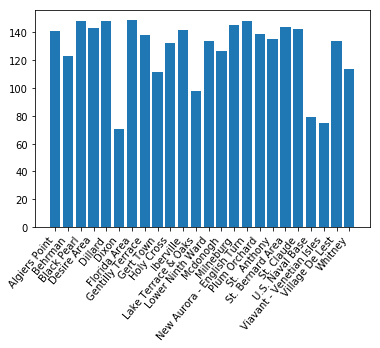

In [13]:
bar_price(price_low, p_low)

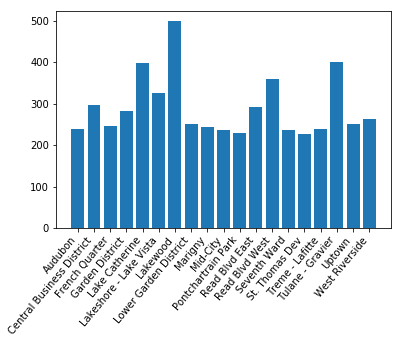

In [14]:
bar_price(price_high, p_high)

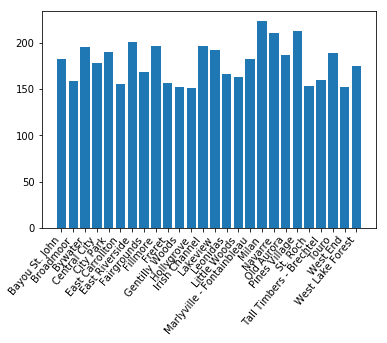

In [15]:
bar_price(price_mid, p_mid)

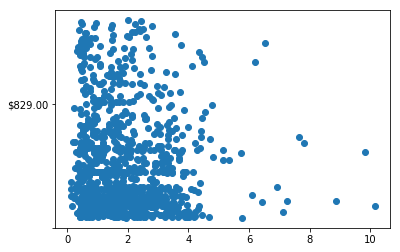

In [16]:

sample = train.sample(1000, random_state=42)
labels = ['0','50','100','150','200','250','300','350','400','450','500']
train['price']=(train['price'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))
price = sample['price']
dist = sample['distance_center']
fig, ax = plt.subplots()
ax.scatter(dist, price)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 150))

In [99]:
label_encoder=LabelEncoder()
label_encoder.fit(train['property_type'])
train['property_type']=label_encoder.transform(train['property_type'])
label_encoder.fit(train['room_type'])
train['room_type']=label_encoder.transform(train['room_type'])
label_encoder.fit(train['distance_center'])
train['distance_center']=label_encoder.transform(train['distance_center'])
train1 = pd.DataFrame({'Dist':train['distance_center'],'Room':train['room_type'],'BA':train['bathrooms'], 'Prop':train['property_type'],'BR':train['bedrooms'], 'Beds': train['beds'],'Acc':train['accommodates'],'Price':train['price']})
# train1 = pd.DataFrame({'Dist':train['distance_center'],'Price':train['price']})

train1.head()


,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,5591,0,2.0,10,3.0,3.0,4,300.0
1,5502,0,1.0,1,1.0,1.0,3,100.0
2,1630,0,1.0,18,1.0,1.0,2,125.0
3,3622,1,2.0,18,1.0,1.0,2,115.0
4,4571,0,1.0,18,1.0,1.0,2,50.0


In [100]:
train1.isnull().sum()

Dist     0
Room     0
BA       2
Prop     0
BR       1
Beds     2
Acc      0
Price    0
dtype: int64

In [101]:
bins = [0, .5,1,2,4,6, 10]
labels = [1, 2, 3, 4, 5, 6]

# train1['Dist'] = pd.cut(train1['Dist'], bins=bins, labels=labels).astype('int')
# train1['Dist'] = pd.cut(train1['Dist'], bins=bins, labels=labels)
bins1 = [0,50,100, 150, 250,300,350, 400, 450, 500, 600, 1000, 8000]
labels1 = [1,2,3,4, 5,6, 7, 8, 9, 10, 11, 12]
# train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1).astype('int')
train1['Price'] = pd.cut(train1['Price'], bins=bins1, labels=labels1)
# train1 = train1.sample(5000, random_state=42)
train1
# train1.to_csv('train.csv', index=False)

,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,5591,0,2.0,10,3.0,3.0,4,5
1,5502,0,1.0,1,1.0,1.0,3,2
2,1630,0,1.0,18,1.0,1.0,2,3
3,3622,1,2.0,18,1.0,1.0,2,3
4,4571,0,1.0,18,1.0,1.0,2,1
5,2764,0,1.0,14,1.0,1.0,2,3
6,3923,0,1.0,1,1.0,1.0,2,3
7,2263,0,1.0,1,1.0,1.0,2,3
8,3904,1,1.0,1,1.0,1.0,2,2
9,2750,0,1.0,1,2.0,3.0,5,2


In [102]:

train1 = train1.dropna()
train1.head()

,Dist,Room,BA,Prop,BR,Beds,Acc,Price
0,5591,0,2.0,10,3.0,3.0,4,5
1,5502,0,1.0,1,1.0,1.0,3,2
2,1630,0,1.0,18,1.0,1.0,2,3
3,3622,1,2.0,18,1.0,1.0,2,3
4,4571,0,1.0,18,1.0,1.0,2,1


In [103]:


from sklearn.preprocessing import StandardScaler

x = train1.drop('Price', axis=1)
y = train1['Price']
print(x.shape, y.shape)


(6628, 7) (6628,)


In [104]:
clf = KNeighborsClassifier(n_neighbors = 5)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.29496270271994457


In [105]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.36361134274764983


In [106]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.39303472725367156


In [107]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.3700949633862376


In [108]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, x, y, cv=k_fold, n_jobs=1, scoring=scoring)

print(score.mean())

0.27971980332918667


In [109]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, stratify=y)

x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.fit_transform(x_test)


# Step 1: Label-encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)
# y_scaler = StandardScaler()
# encoded_y_train = (y_train)
# encoded_y_test = (y_test)


# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)
print(x_train_scaled.shape, y_train_categorical.shape)
print(x_test_scaled.shape, y_test_categorical.shape)


(3314, 7) (3314, 12)
(3314, 7) (3314, 12)


In [123]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create model and add layers
model = Sequential()
model.add(Dense(units=1000, activation='relu', input_dim=7))
model.add(Dense(units=1000, activation='softplus'))
model.add(Dense(units=12, activation='softmax'))
# model.add(Flatten())
# model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1000)              8000      
_________________________________________________________________
dense_26 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_27 (Dense)             (None, 12)                12012     
Total params: 1,021,012
Trainable params: 1,021,012
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.compile(optimizer='adam',
              loss='mean_squared_logarithmic_error',
              metrics=['accuracy'])
# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.fit(
    x_train_scaled,
    y_train_categorical,
    epochs=10,
    shuffle=True,
    verbose=2
)



Epoch 1/10
 - 2s - loss: 0.0320 - acc: 0.3573
Epoch 2/10
 - 1s - loss: 0.0313 - acc: 0.3684
Epoch 3/10
 - 1s - loss: 0.0312 - acc: 0.3681
Epoch 4/10
 - 1s - loss: 0.0308 - acc: 0.3781
Epoch 5/10
 - 1s - loss: 0.0305 - acc: 0.3832
Epoch 6/10
 - 1s - loss: 0.0303 - acc: 0.3929
Epoch 7/10
 - 1s - loss: 0.0303 - acc: 0.3847
Epoch 8/10
 - 1s - loss: 0.0303 - acc: 0.3881
Epoch 9/10
 - 1s - loss: 0.0300 - acc: 0.3914
Epoch 10/10
 - 1s - loss: 0.0301 - acc: 0.3920


In [125]:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
model_loss, model_accuracy = model.evaluate(x_test_scaled, y_test_categorical, verbose=2)

In [126]:
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.030458257676933498, Accuracy: 0.3792999396589627


In [93]:
# label_encoder=LabelEncoder()

encoded_predictions = model.predict_classes(x_test_scaled[:5])
prediction_labels = label_encoder.inverse_transform(encoded_predictions)
# encoded_predictions

In [94]:
print(f"Predicted classes: {prediction_labels}")
print(f"Actual Labels: {list(y_test[:5])}")


Predicted classes: [2 4 3 3 4]
Actual Labels: [2, 3, 3, 3, 3]
